# Permutation tests

Any machine learning method is bound to find correlations in a data if the dataset is small enough. This is the cause why training error is smaller than the test error. This makes it hard to judge whether a predictor with weak performance has learned anything or is there anything to learn at all. For that we should compare the performace of a predicxtor with random guessing however this creates two problems:

* How to define random guessing?
* How much should the performance differ from random guessing?

Answers to these questions can be quite complex. Fortunately permutation tests solve both problems.


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from pandas import Series
from pandas import DataFrame

from tqdm import tnrange
from plotnine import *

from numpy.random import normal
from numpy.random import uniform
from numpy.random import permutation

# Local imports
from common import *
from convenience import *

from sklearn.linear_model import LinearRegression

## I. Example problem

Let us explore this problem in practice by trying to quantify whether the following dataset contains a linear trend.

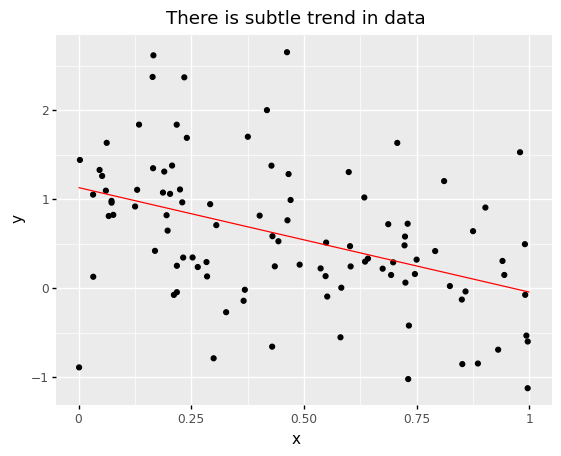

<ggplot: (374715278)>

,x,y
0,0.603465,0.244273
1,0.125478,0.918983
2,0.060638,1.096828
3,0.366093,-0.142173
4,0.979145,1.529162


In [2]:
df = DataFrame({'x': uniform(size=100)}).assign(y = lambda df: 1 - df['x'] + 0.7*normal(size=len(df)))

reg = LinearRegression().fit(df[['x']], df['y'])
pdf = DataFrame({'x': [0, 1]}).assign(y = lambda df: reg.predict(df[['x']]))

p = ggplot(df) + geom_point(aes(x='x', y='y'))
p = p + geom_line(aes(x='x', y='y'), data=pdf, color = 'red')                           
p = p + ggtitle('There is subtle trend in data')

display(p)
head(df)

## II. What information we can use in random guessing?

First of all note that y-values are not uniformly distriuted and thus a uniform choice from range $[-3, 3]$ is not a right choice. 
On the other hand the distribution is also not very close to a normal distribution. So there are no simple choices for random guessing. 

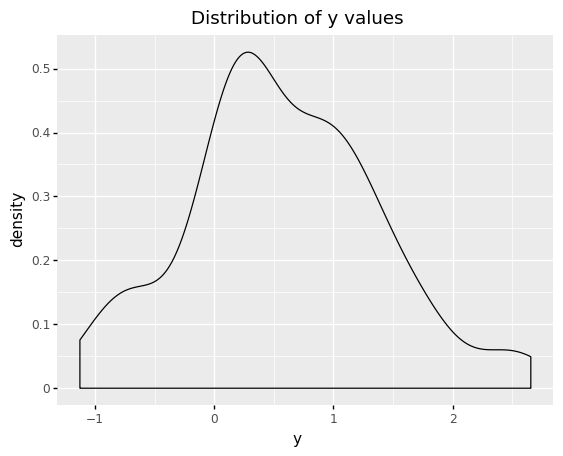

<ggplot: (374818012)>

In [3]:
ggplot(df) + geom_density(aes(x = 'y')) + ggtitle('Distribution of y values') 

### Permutation as a way to destroy casusation between $x$ and $y$

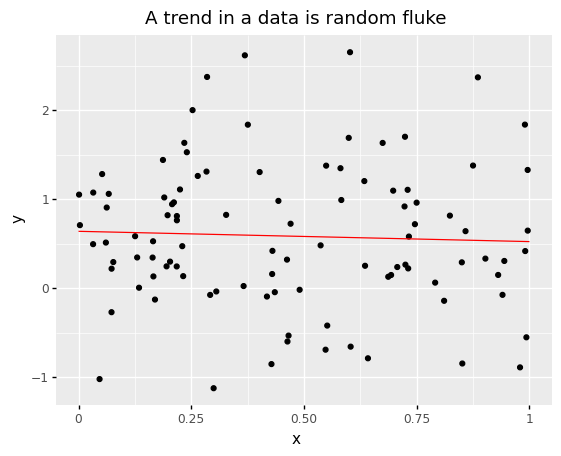

<ggplot: (375008720)>

In [4]:
perm = df.assign(y = lambda df: permutation(df['y']))

reg = LinearRegression().fit(perm[['x']], perm['y'])
pdf = DataFrame({'x': [0, 1]}).assign(y = lambda df: reg.predict(df[['x']]))

p = ggplot(perm) + geom_point(aes(x='x', y='y'))
p = p + geom_line(aes(x='x', y='y'), data=pdf, color = 'red')                           
p = p + ggtitle('A trend in a data is random fluke')

p

### III. Empirical baseline score

Let us now compute the mean square error distribution for randomly permuted data and compare it with our observation 

In [5]:
from sklearn.metrics import mean_squared_error

In [6]:
k = 1000
mse = [np.nan] * k
for i in range(k):
    perm = df.assign(y = lambda df: permutation(df['y']))
    reg = LinearRegression().fit(perm[['x']], perm['y'])
    mse[i] = mean_squared_error(perm['y'], reg.predict(perm[['x']]))

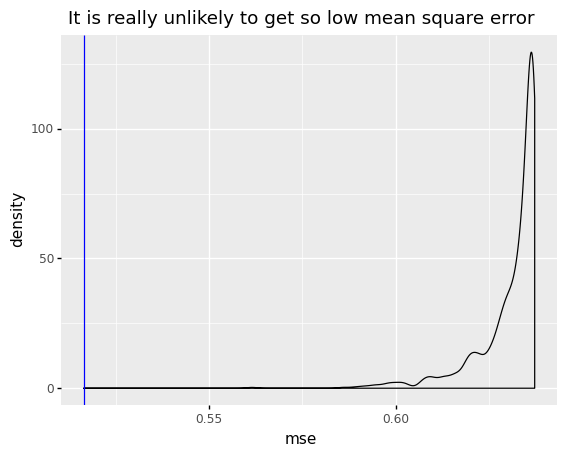

<ggplot: (375057240)>

In [7]:
model = LinearRegression().fit(df[['x']], df['y'])
model_mse = mean_squared_error(df['y'], model.predict(df[['x']]))

p = ggplot(DataFrame({'mse':mse})) + geom_density(aes(x='mse'))
p = p + geom_vline(xintercept = model_mse, color = 'blue')
p = p + ggtitle('It is really unlikely to get so low mean square error') 

display(p)

# Homework

## 5.1 Baseline for linear prediction* (<font color='red'>2p</font>)

Take some benchmark dataset for regression where at least some features are discrete.
* Train a linear predictor. Estimate the training error. 
* Train a linear predictor on the data where all the target values are permuted. Estimate the training error on the permuted dataset. 
* Train a linear predictor on the data where the target values are permuted inside a group that is defined for some discrete feature. Estimate the training error on the permuted dataset. 

Repeat permutations so that you get distributions for the training error. Estimate where the original training error is located inside these distributions and interpret the results(<font color='red'>1p</font>). 

In order to quantify how much informations is lost by permuting you can compute the test error of last two models on the original data. You might see the difference between them. Why?

In [8]:
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)
print(reg.predict(np.array([[3, 5]])))
print(reg.predict(X))

1.0
[1. 2.]
3.0000000000000018
[16.]
[ 6.  8.  9. 11.]
